# <center> Dota 2 winner prediction

<img src='https://habrastorage.org/webt/ua/vn/pq/uavnpqfoih4zwwznvxubu33ispy.jpeg'>

#### <center> Originally done by Peter Romov, translated and adapted by Yury Kashnitskiy (@yorko)
    
### Quick start

Grab features prepared by organizers, train a model and submit. 

1. [Data description](#Data-description)
2. [Features created by organizers](#Features-created-by-organizers)
3. [Training and evaluating a model](#Training-and-evaluating-a-model)
4. [Preparing a submission](#Preparing-a-submission)

### Now do it as a real Data Scientist

5. [Cross-validation](#Cross-validation)
6. [Working with all available information on Dota games](#Working-with-all-available-information-on-Dota-games)
7. [Feature engineering](#Feature-engineering)
8. [How to build initial features from scratch](#How-to-build-initial-features-from-scratch)

## Data description

We have the following files:

- `sample_submission.csv`: example of a submission file
- `train_matches.jsonl`, `test_matches.jsonl`: full "raw" training data 
- `train_features.csv`, `test_features.csv`: features created by organizers
- `train_targets.csv`: results of training games (including the winner)

## Features created by organizers

These are basic features which include simple players' statistics. Scroll to the end to see how to build these features from raw json files.

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import numpy as np
import pandas as pd

from pathlib import Path
PATH_TO_DATA = Path('data/DOTA2/')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, GridSearchCV, cross_val_score
import lightgbm as lgb
import catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

import datetime


In [127]:
prs_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_matches.csv'), 
                                             index_col='match_id_hash')

prs_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_matches.csv'), 
                                             index_col='match_id_hash')

In [16]:
train_y = pd.read_csv(PATH_TO_DATA / 'train_targets.csv', index_col='match_id_hash')['radiant_win']
train_y = train_y.map({True: 1, False: 0})
target = train_y.values


train_df = pd.read_csv(PATH_TO_DATA / 'train_features.csv', index_col='match_id_hash')
test_df = pd.read_csv(PATH_TO_DATA / 'test_features.csv', index_col='match_id_hash')


full_df = pd.concat([train_df, test_df], sort=False)
train_size = train_df.shape[0]

In [17]:
set(list(prs_train.columns)) - set(list(train_df.columns))

{'d_tower_kills', 'diff_tower_kills', 'r_tower_kills', 'target'}

In [143]:
(add_fea_full_df.r_all_towers_killed.values[:train_size] == prs_train.r_tower_kills.values).sum()

23807

In [ ]:
ext

In [138]:
prs_train.r_tower_kills.shape

(39675,)

In [131]:
set(list(train_df.columns)) - set(list(prs_train.columns))

{'chat_len',
 'd1_teamfight_participation',
 'd1_towers_killed',
 'd2_teamfight_participation',
 'd2_towers_killed',
 'd3_teamfight_participation',
 'd3_towers_killed',
 'd4_teamfight_participation',
 'd4_towers_killed',
 'd5_teamfight_participation',
 'd5_towers_killed',
 'game_time',
 'lobby_type',
 'objectives_len',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r3_teamfight_participation',
 'r3_towers_killed',
 'r4_teamfight_participation',
 'r4_towers_killed',
 'r5_teamfight_participation',
 'r5_towers_killed'}

In [8]:
## Preparing a submission

def submit_file(y_pred, prefix='', path='.'):
    df_submission = pd.DataFrame({'radiant_win_prob': y_pred}, 
                                     index=test_df.index)
    submission_filename = '{}/{}_submission_{}.csv'.format(path, prefix,
        datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    df_submission.to_csv(submission_filename)
    
    print('Submission saved to {}'.format(submission_filename))
    return df_submission

def check_logit(X, y, logit=None, train_size=train_size):
    X = StandardScaler().fit_transform(X)[:train_size]
    if not logit:
        logit = LogisticRegression()

    cv_score = cross_val_score(logit, X, y, scoring='roc_auc', cv=5, n_jobs=4)
    return cv_score.mean(), cv_score.std()

-----

In [148]:
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [149]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [150]:
%%time
df_new_features = []
df_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    df_new_features.append(features)
    df_new_targets.append(targets)
    

CPU times: user 1min 9s, sys: 2.12 s, total: 1min 11s
Wall time: 1min 11s


In [151]:
df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')

In [152]:
test_new_features = []
for match in read_matches(os.path.join(PATH_TO_DATA, 'test_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    
    test_new_features.append(features)
test_new_features = pd.DataFrame.from_records(test_new_features).set_index('match_id_hash')

In [182]:
new_full_df = pd.concat([df_new_features, test_new_features],axis=0)

In [183]:
new_full_df.shape

(49675, 305)

In [184]:
add_df_new_features = pd.DataFrame(index=new_full_df.index)
additive_col = []
pre_additive_col = ['kills', 'deaths', 'assists', 'denies', 'gold', 'xp', 'rune_pickups', 
                    'towers_killed', 'lh', 'max_mana', 'level', 'stuns', 
                    'creeps_stacked', 'camps_stacked', 'firstblood_claimed', 'teamfight_participation', 
                    'towers_killed', 'roshans_killed', 'ability_level', 'max_hero_hit', 'purchase_count',
                    'max_health', 'r1_obs_placed', 'r1_sen_placed', 'count_ability_use', 'damage_dealt', 
                    'damage_received', 
                   ]
for w in pre_additive_col:
    cur_c = []
    for c in new_full_df.columns:
        if w in c:
            cur_c.append(c)
            additive_col.append(c)
    for team in 'rd':
#         print([c for c in cur_c if c.startswith(team)])
        add_df_new_features[f'{team}_all_{w}'] = new_full_df[[c for c in cur_c if c.startswith(team)]].sum(axis=1)

In [185]:
add_df_new_features.shape

(49675, 52)

In [186]:
check_logit(add_df_new_features, y)

(0.8154912794390666, 0.0050760966484372436)

We have ~ 40k games, each described by `match_id_hash` (game id) and 245 features. Also `game_time` is given - time (in secs) when the game was over. 

In [9]:
train_df.shape

(39675, 245)

In [10]:
train_df.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.00,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.25,0,0,0,0


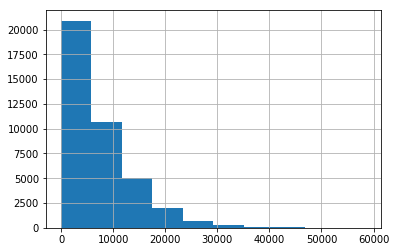

In [18]:
train_df.r1_gold.hist()

## Training and evaluating a model

#### Train the Random Forest model

In [127]:
# %%time
# model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
# model.fit(X_train, y_train)
# y_pred = model.predict_proba(X_valid)[:, 1]
# valid_score = roc_auc_score(y_valid, y_pred)
# print('Validation ROC-AUC score trees:', valid_score)
# valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
# print('Validation accuracy of P>0.5 classifier:', valid_accuracy)

**And logit**

In [19]:
%%time
check_logit(train_df.values[:train_size], y)

CPU times: user 250 ms, sys: 193 ms, total: 443 ms
Wall time: 14.5 s


(0.8124758031774638, 0.004381519777706034)

## Dummies of heroes

In [20]:
hero_columns = [c for c in full_df.columns if '_hero_' in c]
hero_df = full_df[hero_columns]

In [21]:
for team in 'r', 'd':
    players = [f'{team}{i}' for i in range(1, 6)]
    part_hero_columns = [f'{player}_hero_id' for player in players]
    d = pd.get_dummies(hero_df[part_hero_columns[0]])
    for c in part_hero_columns[1:]:
        d += pd.get_dummies(hero_df[c])
    hero_df = pd.concat([hero_df, d.add_prefix(f'{team}_hero_')], axis=1)
    hero_df.drop(columns=part_hero_columns, inplace=True)
    
X = hero_df.iloc[:train_size, :]

In [22]:
X.shape

(39675, 230)

In [23]:
check_logit(X, y) # on only hero features

(0.6050825241561846, 0.008542256139390678)

In [24]:
mod_full_df = pd.concat([full_df.drop(hero_columns, axis=1), hero_df], axis=1)
mod_full_df.shape

(49675, 465)

In [25]:
%%time
print(check_logit(mod_full_df.values[:train_size], y))

(0.8315638402951275, 0.001821867590201962)
CPU times: user 807 ms, sys: 526 ms, total: 1.33 s
Wall time: 21.6 s


In [26]:
location_col = [c for c in full_df.columns if c.endswith('_x') or c.endswith('_y')]
location_df = full_df[location_col]
clus_location_df = location_df // 10

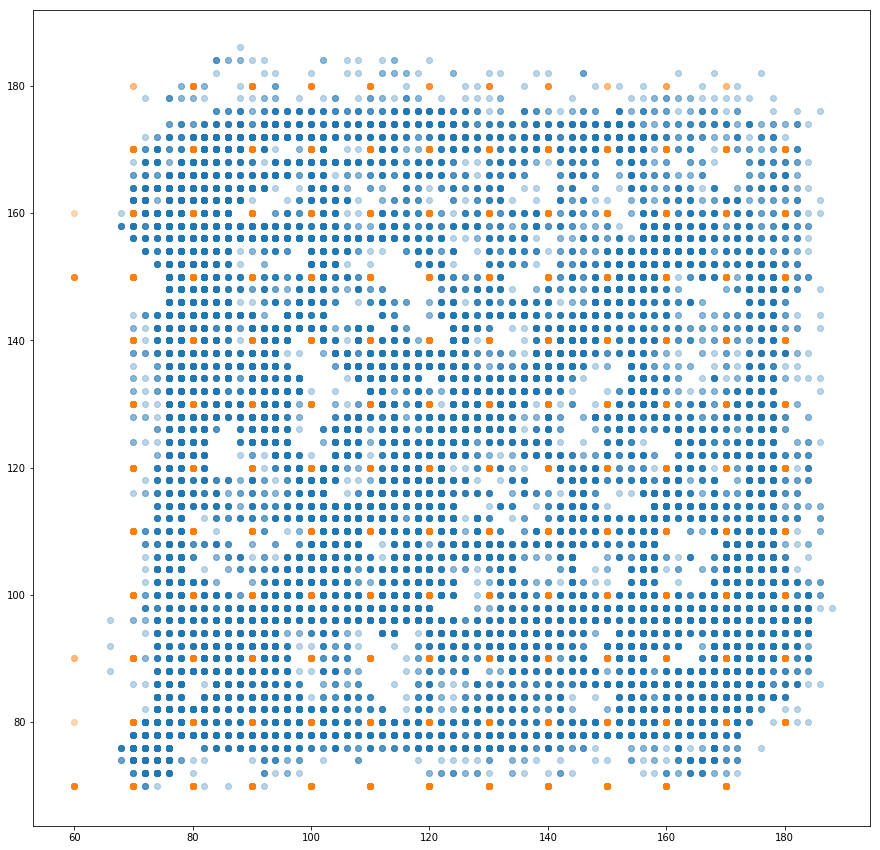

In [27]:
cl_id = 10
plt.figure(figsize=(15,15))
for COM in 'rd':
    for i in range(1,6):
        plt.scatter(location_df[f'{COM}{i}_x'], location_df[f'{COM}{i}_y'], alpha=0.3)
        plt.scatter(location_df[f'{COM}{i}_x'] // cl_id * cl_id, 
                    location_df[f'{COM}{i}_y'] // cl_id * cl_id, alpha=0.3)
        break
    break

In [28]:
add_fea_full_df = pd.DataFrame(index=full_df.index)
additive_col = []
pre_additive_col = ['kills', 'deaths', 'assists', 'denies', 'gold', 'xp', 'rune_pickups', 
                    'towers_killed', 'lh', 'max_mana', 'level', 'stuns', 
                    'creeps_stacked', 'camps_stacked', 'firstblood_claimed', 'teamfight_participation', 
                    'towers_killed', 'roshans_killed', 
                    'max_health', 'r1_obs_placed', 'r1_sen_placed',
                   ]
for w in pre_additive_col:
    cur_c = []
    for c in full_df.columns:
        if w in c:
            cur_c.append(c)
            additive_col.append(c)
    for team in 'rd':
#         print([c for c in cur_c if c.startswith(team)])
        add_fea_full_df[f'{team}_all_{w}'] = full_df[[c for c in cur_c if c.startswith(team)]].sum(axis=1)

In [29]:
for COM in 'rd':
    add_fea_full_df[f'{COM}_all_xped_gold'] = add_fea_full_df[f'{COM}_all_gold'] / 10000 * add_fea_full_df[f'{COM}_all_xp'] / 7000

add_fea_full_df = add_fea_full_df.drop(['r_all_kills', 'd_all_kills', 
#                                         'd_all_gold', 'r_all_gold', 
                                        'r_all_xp', 'd_all_xp', 
#                                         'd_all_level'
                                       ], axis=1,)

In [30]:
check_logit(add_fea_full_df, y)

(0.8147017831528036, 0.004880740926150591)

In [31]:
check_logit(pd.concat([full_df[additive_col + location_col], hero_df], axis=1), y)

(0.8311817515656414, 0.0019300994227860223)

In [415]:
check_logit(pd.concat([hero_df, add_fea_full_df, clus_location_df], axis=1), y, )

(0.8351941374924292, 0.001704526395633516)

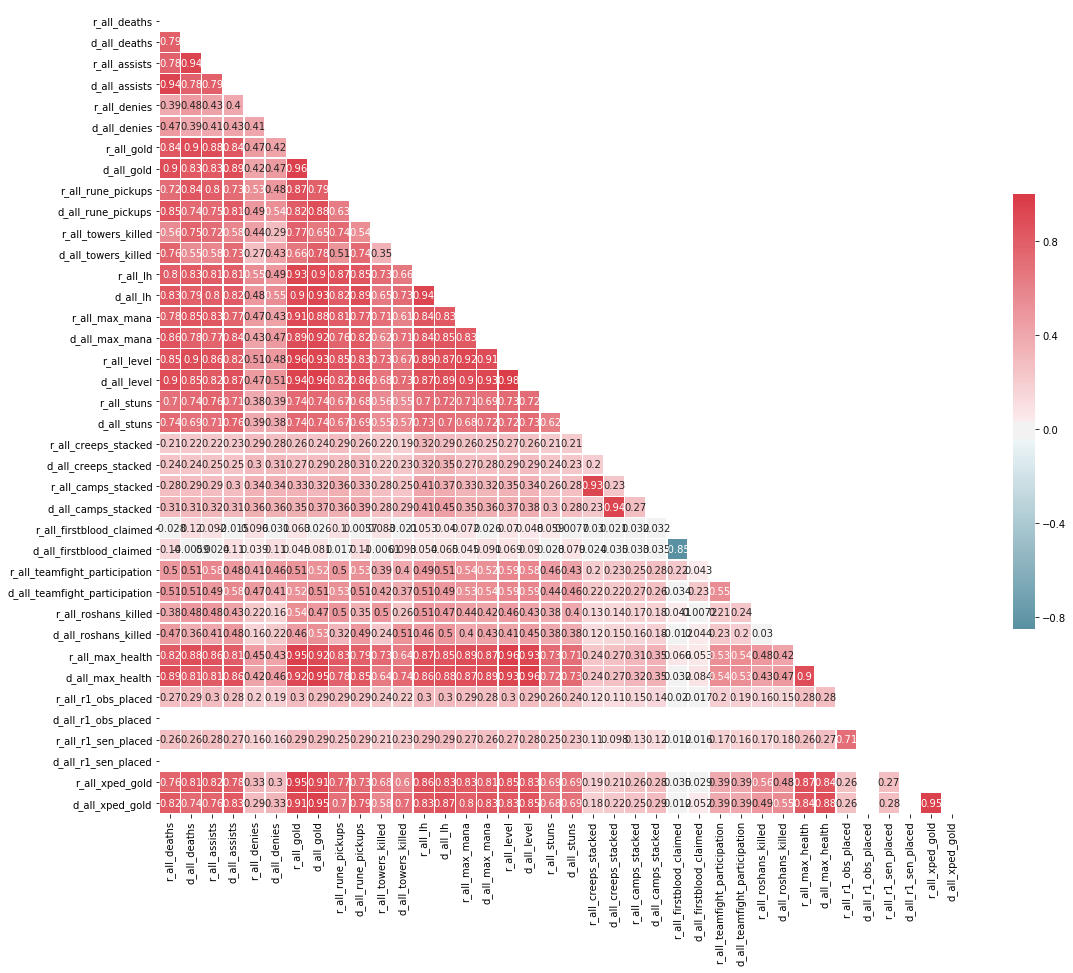

In [379]:
# Compute the correlation matrix
corr = add_fea_full_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18,16))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, )
# plt.savefig('corr_map.png')

In [32]:
add_fea_full_df.shape

(49675, 38)

In [218]:
[c for c in full_df.columns if 'r1_' in c]

['r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed']

In [37]:
for col in full_df.columns:
    if not (col.startswith('r') or col.startswith('d')):
        print(col)

game_time
game_mode
lobby_type
objectives_len
chat_len


In [40]:
full_df.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.00,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.25,0,0,0,0


In [94]:
lost_col = ['game_time', ]
lost_df = full_df[lost_col]
# lost_df.lobby_type.replace(7, 1, inplace=True)

In [188]:
# my_full_df = pd.concat([hero_df, add_fea_full_df, clus_location_df, lost_df], axis=1)

my_full_df = pd.concat([hero_df, add_df_new_features, clus_location_df, lost_df], axis=1)

In [196]:
check_logit(my_full_df.values, y, )

(0.8344095534538157, 0.0022364521570745156)

In [195]:
my_full_df.count().unique()

array([49675])

In [197]:
# param = {'num_leaves': 200, 
#          'metric': 'roc_auc', 
#          'verbosity' : 0, 
#          'max_depth': -1, 
#          'learning_rate': 0.01, 
#          'num_threads': 4, 
#          'reg_alpha': 0.01, 
#          'reg_lambda': 3
# }
param = {
    "objective" : "binary",
    "metric" : 'auc',
#      'boost' : "gbdt",
    'boost_from_average' : "false",
#     'tree_learner': "serial",
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_fraction" : 0.4,
     'bagging_freq' : 5,
     'min_data_in_leaf' : 80,
     'min_sum_hessian_in_leaf' : 10.0,
    "feature_fraction" : 0.05,
#     "lambda_l1" : 5,
#     "lambda_l2" : 5,
    "bagging_seed" : 42,
    "verbosity" : 1,
    "random_state": 4950,
     'num_threads': 4,
}

df_train, df_test = my_full_df.iloc[:train_size], my_full_df.iloc[train_size:]
target = train_y
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=31415)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx],target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx], label=target.iloc[val_idx])
    lgb_model = lgb.train(param, trn_data, 40000, 
                          valid_sets = [trn_data, val_data], 
                          early_stopping_rounds=2000, 
                          verbose_eval=1000)
#                          categorical_feature= category_features )          
    oof[val_idx] = lgb_model.predict(df_train.iloc[val_idx], num_iteration = lgb_model.best_iteration)
    predictions += lgb_model.predict(df_test, num_iteration = lgb_model.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 2000 rounds.
[1000]	training's auc: 0.829429	valid_1's auc: 0.805951
[2000]	training's auc: 0.851551	valid_1's auc: 0.819002
[3000]	training's auc: 0.867104	valid_1's auc: 0.825929
[4000]	training's auc: 0.878602	valid_1's auc: 0.829688
[5000]	training's auc: 0.887967	valid_1's auc: 0.831853
[6000]	training's auc: 0.89603	valid_1's auc: 0.832956
[7000]	training's auc: 0.903313	valid_1's auc: 0.833249
[8000]	training's auc: 0.909938	valid_1's auc: 0.833524
[9000]	training's auc: 0.915616	valid_1's auc: 0.833505
[10000]	training's auc: 0.921191	valid_1's auc: 0.833471
Early stopping, best iteration is:
[8447]	training's auc: 0.912572	valid_1's auc: 0.833699
Fold 1
Training until validation scores don't improve for 2000 rounds.
[1000]	training's auc: 0.830784	valid_1's auc: 0.801401
[2000]	training's auc: 0.853417	valid_1's auc: 0.814114
[3000]	training's auc: 0.868315	valid_1's auc: 0.820012
[4000]	training's auc: 0.879915	valid_1

In [199]:
_ = submit_file(predictions)

Submission saved to ./_submission_2019-04-21_19-49-19.csv


In [204]:
logit = LogisticRegression()
sc = StandardScaler()
X = sc.fit_transform(df_train)
X_test = sc.transform(df_test)
ly_pred = logit.fit(X, target).predict_proba(X_test)[:, 1]

In [205]:
ly_pred

array([0.18136463, 0.97427256, 0.95242177, ..., 0.50624893, 0.8271202 ,
       0.06788731])

In [206]:
predictions

array([0.21392895, 0.98623192, 0.950771  , ..., 0.33947035, 0.83247634,
       0.12034529])

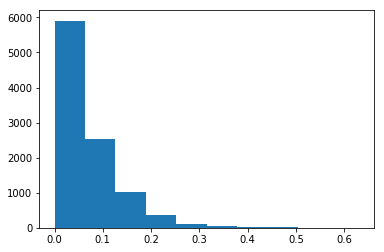

In [209]:
_ = plt.hist(np.abs(ly_pred - predictions))

In [226]:
mix_pred = predictions * 0.5 + ly_pred * 0.4

In [227]:
submit_file(mix_pred)

Submission saved to ./_submission_2019-04-21_20-06-02.csv


,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.179510
70e5ba30f367cea48793b9003fab9d38,0.882825
4d9ef74d3a2025d79e9423105fd73d41,0.856354
2bb79e0c1eaac1608e5a09c8e0c6a555,0.663539
bec17f099b01d67edc82dfb5ce735a43,0.163459
038acbb47d9eb54c11962d07cce8d829,0.099852
b891f03bb2a86d78b84043437fc95e04,0.864471
ff898afdb5bb5c7163bde45a009503f7,0.046658
72e6b1c31c718c0806f9aaeb8b7290a9,0.581114


In [219]:
round(0.51, 0)

1.0

In [220]:
mm = []
for x1,x2 in zip(predictions, ly_pred):
    X = np.mean([x1,x2])
    if abs(x1-x2) < .5 and x1 > 0.7 or x2 > 0.7:
        X = 1
    if abs(x1-x2) < .5 and x1 < 0.3 or x2 < 0.3:
        X = 0
    mm.append(X)

In [222]:
_ = submit_file(mm)

Submission saved to ./_submission_2019-04-21_20-02-02.csv


In [185]:
full_df[[c for c in full_df.columns if 'health' in c]].head()

,r1_health,r1_max_health,r2_health,r2_max_health,r3_health,r3_max_health,r4_health,r4_max_health,r5_health,r5_max_health,d1_health,d1_max_health,d2_health,d2_max_health,d3_health,d3_max_health,d4_health,d4_max_health,d5_health,d5_max_health
match_id_hash,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,358,600,636,720,700,700,399,700,422,800,650,720,640,640,720,720,760,760,593,680
b9c57c450ce74a2af79c9ce96fac144d,1160,1160,1352,1380,710,860,420,880,856,900,700,700,758,1040,485,800,567,1160,800,800
6db558535151ea18ca70a6892197db41,680,680,720,720,568,600,580,580,580,580,660,660,586,620,660,660,600,600,640,640
46a0ddce8f7ed2a8d9bd5edcbb925682,900,900,878,1100,980,980,640,640,1079,1100,825,1160,735,880,817,860,1160,1160,630,740
b1b35ff97723d9b7ade1c9c3cf48f770,1000,1000,868,1000,578,860,777,980,281,820,709,940,712,820,349,720,680,680,692,740


In [229]:
full_df[[c for c in full_df.columns if 'obs_placed' in c]].head()

,r1_obs_placed,r2_obs_placed,r3_obs_placed,r4_obs_placed,r5_obs_placed,d1_obs_placed,d2_obs_placed,d3_obs_placed,d4_obs_placed,d5_obs_placed
match_id_hash,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,0,0,0,0,0,0,0,0,1,0
b9c57c450ce74a2af79c9ce96fac144d,0,0,3,1,0,1,4,0,0,0
6db558535151ea18ca70a6892197db41,0,0,0,0,0,0,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,0,0,2,2,0,0,1,0,0,2
b1b35ff97723d9b7ade1c9c3cf48f770,0,0,0,0,0,0,0,0,0,0


The second model is preferred. Look, there's a caveat here: the second model is actually better for 4 splits out of 5. So if we were to perform only one train/test split, there would've been a 20% probability to make a wrong conclusion that the first model is better.

In [22]:
cv_scores_rf2 > cv_scores_rf1

array([ True, False,  True,  True,  True])

## Working with all available information on Dota games
Raw data descriptions for all games are given in files `train_matches.jsonl` and `test_matches.jsonl`. Each file has one entry for each game in [JSON](https://en.wikipedia.org/wiki/JSON) format. You only need to know that it can be easily converted to Python objects via the `json.loads` method.

##### Let's explore a single entry

In [97]:
import json

with open(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

The `match` object is now a big Python dictionary. In `match['players']` we have a description of each player.

You might think that this `match` object look ugly. You're right! That's actually the real data. And it's the ability to extract nice features from raw data that makes good Data Scientists stand out. You might even be unfamiliar with Dota (or any other application domain) but still be able to construct a good model via feature engineering. It's art and craftmanship at the same time.   

In [98]:
#match

In [99]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [100]:
match['targets']

{'game_time': 2388,
 'duration': 2763,
 'time_remaining': 375,
 'radiant_win': True,
 'next_roshan_team': 'Dire'}

#### Player description

In [101]:
player = match['players'][3]

KDA: the number of kills, deaths, and assists to alleys.

In [102]:
player['kills'], player['deaths'], player['assists']

(7, 9, 14)

Some statistics on player abilities:

In [103]:
player['ability_uses']

{'tidehunter_gush': 65, 'tidehunter_anchor_smash': 73, 'tidehunter_ravage': 9}

In [105]:
player['ability_uses']

{'tidehunter_gush': 65, 'tidehunter_anchor_smash': 73, 'tidehunter_ravage': 9}

In [426]:
player['ability_upgrades']

[{'ability': 5495, 'time': 136, 'level': 1},
 {'ability': 5496, 'time': 330, 'level': 2},
 {'ability': 5495, 'time': 422, 'level': 3},
 {'ability': 5494, 'time': 473, 'level': 4},
 {'ability': 5494, 'time': 650, 'level': 5},
 {'ability': 5497, 'time': 804, 'level': 6},
 {'ability': 5496, 'time': 870, 'level': 7},
 {'ability': 5494, 'time': 1026, 'level': 8},
 {'ability': 5494, 'time': 1117, 'level': 9},
 {'ability': 5495, 'time': 1202, 'level': 10},
 {'ability': 5495, 'time': 1328, 'level': 11},
 {'ability': 5497, 'time': 1341, 'level': 12},
 {'ability': 6029, 'time': 1420, 'level': 13},
 {'ability': 5496, 'time': 1454, 'level': 14},
 {'ability': 5496, 'time': 1619, 'level': 15},
 {'ability': 6078, 'time': 1667, 'level': 16},
 {'ability': 5497, 'time': 1798, 'level': 17},
 {'ability': 6892, 'time': 2044, 'level': 18}]

In [428]:
player['purchase']

{'stout_shield': 1,
 'quelling_blade': 1,
 'tango': 1,
 'tpscroll': 7,
 'gloves': 1,
 'boots': 1,
 'belt_of_strength': 2,
 'power_treads': 1,
 'orb_of_venom': 1,
 'magic_stick': 1,
 'shadow_amulet': 1,
 'claymore': 1,
 'invis_sword': 1,
 'ogre_axe': 1,
 'sobi_mask': 1,
 'robe': 1,
 'quarterstaff': 1,
 'oblivion_staff': 1,
 'echo_sabre': 1,
 'branches': 2,
 'magic_wand': 1,
 'enchanted_mango': 1,
 'recipe_silver_edge': 1,
 'silver_edge': 1,
 'ultimate_orb': 1,
 'javelin': 1,
 'basher': 1,
 'recipe_basher': 1,
 'ring_of_health': 1,
 'recipe_abyssal_blade': 1,
 'vanguard': 1,
 'abyssal_blade': 1,
 'vitality_booster': 1}

In [106]:
player['account_id_hash']

'dcc8416a0b0ddcbff3a28a34a4ce5ec2'

In [62]:
new_fea = list(set(list(player.keys())) - set([c[3:] for c in full_df.columns if 'r1_' in c]))

In [421]:
player['randomed']

False

In [427]:
player['item_uses']

{'tpscroll': 7,
 'quelling_blade': 1,
 'tango': 3,
 'power_treads': 68,
 'shadow_amulet': 2,
 'magic_stick': 6,
 'invis_sword': 14,
 'magic_wand': 10,
 'silver_edge': 13}

In [417]:
new_fea

['obs_log',
 'account_id_hash',
 'runes_log',
 'ability_uses',
 'gold_reasons',
 'purchase_log',
 'sen_log',
 'observers_placed',
 'ability_upgrades',
 'damage_taken',
 'life_state',
 'damage',
 'max_hero_hit',
 'times',
 'sen_left_log',
 'xp_t',
 'buyback_log',
 'obs',
 'actions',
 'killed',
 'runes',
 'hero_name',
 'healing',
 'purchase',
 'dn_t',
 'randomed',
 'pings',
 'lh_t',
 'damage_inflictor',
 'player_slot',
 'sen',
 'obs_left_log',
 'killed_by',
 'hero_stash',
 'nearby_creep_death_count',
 'hero_inventory',
 'item_uses',
 'kill_streaks',
 'xp_reasons',
 'hero_hits',
 'pred_vict',
 'gold_t',
 'damage_inflictor_received',
 'kills_log',
 'multi_kills']

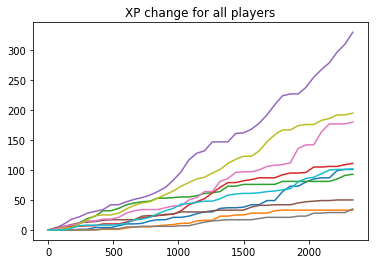

In [97]:
for player in match['players']:
    plt.plot(player['times'], player['lh_t'])
    
plt.title('XP change for all players');

#### Example: time series for each player's gold.

In [62]:
%matplotlib inline
from matplotlib import pyplot as plt

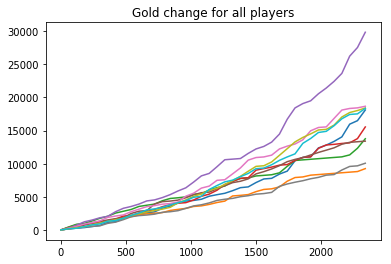

In [63]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
    
plt.title('Gold change for all players');

#### Function to read files with game descriptions

The following function `read_matches(filename)`, can be used to read raw data on Dota 2 games.

We recommend to install two Python packages: `ujson` and `tqdm`, it'll make the execution faster and 

In [109]:
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

#### Reading data in a loop

Reading data on all games might take some 2-3 minutes. Thus you'd better stick to the following approach:

1. Read a small amount (10-100) of games
2. Write code to extract features from these JSON objects
3. Make sure the code works fine
4. Run the code with all available data
5. Save results to a `pickle` file so that you don't need to run all computations from scratch next time 

In [110]:
for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    game_time = match['game_time']
    
    # processing each game
    
    for player in match['players']:
        pass  # processing each player

KeyboardInterrupt: 

## Feature engineering

In [112]:
def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write new features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
        
        # ... here you can add more features ...
        

In [114]:
# copy the dataframe with features
df_train_features_extended = train_df.copy()

# add new features
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              'train_matches.jsonl'))

We see new features added to the right.

In [147]:
df_train_features_extended.iloc[:, -3:]

,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,
a400b8f29dece5f4d266f49f1ae2e98a,0.0,0.0,0.0
b9c57c450ce74a2af79c9ce96fac144d,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,0.0,0.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,0.0,0.0,0.0
b1b35ff97723d9b7ade1c9c3cf48f770,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,0.0,1.0,-1.0
df50f738c454d430a33b2bf90cb9ef1a,0.0,0.0,0.0


#### Evaluating new features

Let's run cross-validation with a fixed model but with two different datasets:

1. with features built by organizers (base)
2. with new features that we've added (extended)

In [35]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)

cv_scores_base = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_extended = cross_val_score(model, df_train_features_extended.values, y, 
                                     cv=cv, scoring='roc_auc', n_jobs=-1)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 156 ms, sys: 300 ms, total: 456 ms
Wall time: 1min 30s


In [36]:
print('Base features: mean={} scores={}'.format(cv_scores_base.mean(), 
                                                cv_scores_base))
print('Extended features: mean={} scores={}'.format(cv_scores_extended.mean(), 
                                                    cv_scores_extended))

Base features: mean=0.7795738699757455 scores=[0.77723183 0.78656801 0.78004904 0.77732062 0.77669984]
Extended features: mean=0.7862340339233831 scores=[0.78570687 0.79044313 0.78708931 0.78227352 0.78565735]


In [37]:
cv_scores_extended > cv_scores_base

array([ True,  True,  True,  True,  True])

As we see, `RandomForestClassifier` shows better cross-validation results in case of the extended dataset. Looks reasonable, that's what we build features for.

#### New submission

In [38]:
%%time
# Build the same features for the test set
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))


CPU times: user 28.8 s, sys: 692 ms, total: 29.5 s
Wall time: 29.2 s


In [39]:
model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
model.fit(X, y)
df_submission_base = pd.DataFrame(
    {'radiant_win_prob': model.predict_proba(df_test_features.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_base.to_csv('submission_base_rf.csv')

In [40]:
model_extended = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
model_extended.fit(df_train_features_extended.values, y)
df_submission_extended = pd.DataFrame(
    {'radiant_win_prob': model_extended.predict_proba(df_test_features_extended.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_extended.to_csv('submission_extended_rf.csv')

In [41]:
# this one will be used as a final submission in this kernel
!cp submission_extended_rf.csv submission.csv

## How to build initial features from scratch

Now we diclose the code that we used to build initial features `train_features.csv` and `test_features.csv`. You can modify the following code to add more features.

In a nutshell:

1. the  `extract_features_csv(match)` function extracts features from game descriptions and writes them into a dictionary
2. the `extract_targets_csv(match, targets)` function extracts the target variable `radiant_win`
3. iterating through the file with raw data, we collect all features
4. with `pandas.DataFrame.from_records()` we create dataframes with new features

In [42]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [43]:
%%time

df_new_features = []
df_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    df_new_features.append(features)
    df_new_targets.append(targets)
    


CPU times: user 1min 11s, sys: 3.21 s, total: 1min 14s
Wall time: 1min 13s


In [44]:
df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')

In [45]:
df_new_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,...,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.938,2,116,122,0.000,0,0,1,0,0.000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.938,...,760,760,326.938,2,90,150,0.000,0,0,2,1,1.0,0,0,1,0,34,0,0,0,0,851,11,870,593,680,566.938,3,128,128,0.000,0,0,0,0,0.00,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,5257,52,3937,1160,1160,566.938,8,76,78,0.000,0,0,0,0,0.438,0,0,0,0,96,3,1,2,3,3394,19,3897,1352,1380,386.938,...,567,1160,410.938,6,124,142,0.000,0,0,6,0,0.5,0,0,0,0,92,0,2,0,1,1423,8,1136,800,800,446.938,4,180,176,0.000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,176,0,0,680,680,506.938,1,118,118,0.000,0,0,0,0,0.000,0,0,0,0,51,0,0,0,0,176,0,0,720,720,278.938,...,600,600,302.938,1,176,110,0.000,0,0,0,0,0.0,0,0,0,0,17,0,0,0,0,96,0,0,640,640,446.938,1,162,162,0.000,0,0,0,0,0.00,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,1613,0,1471,900,900,290.938,4,170,96,2.366,0,0,5,0,0.571,0,0,0,0,99,1,0,1,2,2816,30,3602,878,1100,494.938,...,1160,1160,386.938,4,176,100,4.999,0,0,2,0,0.0,0,0,0,0,86,0,1,0,1,1333,2,1878,630,740,518.938,5,82,160,8.665,3,1,3,0,0.00,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,1404,9,1351,1000,1000,338.938,4,80,164,9.931,0,0,4,0,0.500,0,0,0,0,69,1,0,0,0,1840,14,1693,868,1000,350.938,...,680,680,374.938,4,176,108,13.597,0,0,2,0,0.5,0,0,0,0,1,0,1,1,8,2199,32,1919,692,740,302.938,5,104,162,0.000,2,1,2,0,0.25,0,0,0,0


## Go on!

- Discuss new ideas in Slack 
- Create new features
- Try new models and ensembles
- Submit predictions
- Go and win!